In [0]:
!pip install tqdm
!pip install tqdm --upgrade

Requirement already up-to-date: tqdm in /usr/local/lib/python3.6/dist-packages (4.46.0)


## Librerias

In [1]:
import random
import pandas as pd
import numpy as np
import os

# Preprocesamiento y representacion de imágenes
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from IPython.display import Image
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import SGD
from tqdm.keras import TqdmCallback
from keras.preprocessing import image as krs_image
from keras_preprocessing.image import ImageDataGenerator

# Tensorflow
import tensorflow as tf 
from tensorflow.keras.layers import Conv2D,Activation,MaxPooling2D,Dense,Input,Embedding,Reshape,concatenate,Concatenate,BatchNormalization,Flatten,Dropout
from tensorflow.keras import Model

from tqdm import tqdm

Using TensorFlow backend.


## Importamos el csv y descomprimimos las imágenes

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
#!unzip '/content/drive/My Drive/TFM/data/filtered_img.zip'
!unzip '/content/drive/My Drive/Máster KSchool/TFM/data/filtered_img.zip'

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: filtered_img/tt0246262.png  
  inflating: filtered_img/tt0269281.png  
  inflating: filtered_img/tt0011396.png  
  inflating: filtered_img/tt0078320.png  
  inflating: filtered_img/tt0389361.png  
  inflating: filtered_img/tt0092921.png  
  inflating: filtered_img/tt0115682.png  
  inflating: filtered_img/tt0029609.png  
  inflating: filtered_img/tt0123330.png  
  inflating: filtered_img/tt2006093.png  
  inflating: filtered_img/tt0061671.png  
  inflating: filtered_img/tt0953903.png  
  inflating: filtered_img/tt0322082.png  
  inflating: filtered_img/tt0028517.png  
  inflating: filtered_img/tt4799672.png  
  inflating: filtered_img/tt1305714.png  
  inflating: filtered_img/tt0284137.png  
  inflating: filtered_img/tt0201129.png  
  inflating: filtered_img/tt0038704.png  
  inflating: filtered_img/tt3163244.png  
  inflating: filtered_img/tt0227850.png  
  inflating: filtered_img/tt4799114.png  
  inflating: fi

In [6]:
cols = ['CODE','DURATION','COLOR','YEAR','DIRECTOR','RATING','COUNTRY_0','GENRES_0','GENRES_1','GENRES_2','LANGUAGE_0','KEYWORDS_0','KEYWORDS_1','KEYWORDS_2','WRITERS_0']
#data = pd.read_csv('/content/drive/My Drive/TFM/data/tabular_prueba_4.csv',header=0,decimal=',',usecols=cols)
data = pd.read_csv("/content/drive/My Drive/Máster KSchool/TFM/data/tabular_prueba_5.csv",header=0, decimal=',', usecols=cols)

data['KEYWORDS_1'] = data['KEYWORDS_1'].astype(str)
data['KEYWORDS_2'] = data['KEYWORDS_2'].astype(str)
data['WRITERS_0'] = data['WRITERS_0'].astype(str)
data['CODE'] = data['CODE'].apply(lambda x: x.replace('tt',''))

data.head(5)

,CODE,DURATION,COLOR,YEAR,DIRECTOR,RATING,GENRES_0,GENRES_1,GENRES_2,LANGUAGE_0,KEYWORDS_0,KEYWORDS_1,KEYWORDS_2,COUNTRY_0,WRITERS_0
0,4686108,106,Color,2017,JohnDoe,5.3,Drama,Musical,Drama,English,poetry,college,rap,USA,JaneDoe
1,0445033,162,Color,2004,LawrenceRaghavendra,6.4,Action,Drama,Action,Telugu,mafia,friend,revenge,India,JaneDoe
2,1167599,85,Color,2009,MichaelHerbig,5.5,Action,Adventure,Comedy,German,hidinginabox,hidinginachest,vikingship,Germany,MichaelHerbig
3,4823434,83,Color,2017,IssaLÃƒÂ³pez,7.0,Fantasy,Horror,Mystery,Spanish,mexicanhorror,producedbydirector,titledirectedbyfemale,Mexico,IssaLÃƒÂ³pez
4,0220100,97,Color,2000,MikeFiggis,6.0,Drama,Romance,Drama,English,audition,jealousy,realtime,USA,MikeFiggis


## Preprocesamiento de los datos

#### Categorizamos la variable de salida

In [7]:
data['RATING']  = data['RATING'].astype(float)
data['RATING_CAT'] = pd.cut(data['RATING'], bins = [0, 5, 6.5,10], labels=['0','1','2'])
data.head(5)

,CODE,DURATION,COLOR,YEAR,DIRECTOR,RATING,GENRES_0,GENRES_1,GENRES_2,LANGUAGE_0,KEYWORDS_0,KEYWORDS_1,KEYWORDS_2,COUNTRY_0,WRITERS_0,RATING_CAT
0,4686108,106,Color,2017,JohnDoe,5.3,Drama,Musical,Drama,English,poetry,college,rap,USA,JaneDoe,1
1,0445033,162,Color,2004,LawrenceRaghavendra,6.4,Action,Drama,Action,Telugu,mafia,friend,revenge,India,JaneDoe,1
2,1167599,85,Color,2009,MichaelHerbig,5.5,Action,Adventure,Comedy,German,hidinginabox,hidinginachest,vikingship,Germany,MichaelHerbig,1
3,4823434,83,Color,2017,IssaLÃƒÂ³pez,7.0,Fantasy,Horror,Mystery,Spanish,mexicanhorror,producedbydirector,titledirectedbyfemale,Mexico,IssaLÃƒÂ³pez,2
4,0220100,97,Color,2000,MikeFiggis,6.0,Drama,Romance,Drama,English,audition,jealousy,realtime,USA,MikeFiggis,1


### Seleccionamos las features y las variable de salida del dataset

In [0]:
features = [0,1,2,3,4,6,7,8,9,10,11,12,13,14]
target = [15]
X = data.iloc[:,features]
y = data.iloc[:,target]

### Dividimos entre train y test

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y)
X_train.head(5)

,CODE,DURATION,COLOR,YEAR,DIRECTOR,GENRES_0,GENRES_1,GENRES_2,LANGUAGE_0,KEYWORDS_0,KEYWORDS_1,KEYWORDS_2,COUNTRY_0,WRITERS_0
81159,0181574,90,Color,1999,JohnDoe,Comedy,Crime,Comedy,German,basedonnovel,nan,basedonnovel,Germany,JaneDoe
62245,1388925,84,Color,1976,JohnDoe,Adventure,Drama,Adventure,Turkish,firstpart,partoftrilogy,firstoftrilogy,Turkey,JaneDoe
83922,0048799,111,BlackandWhite,1955,Lars-EricKjellgren,Drama,Drama,Drama,Swedish,military,flashback,courtmartial,Sweden,JaneDoe
93089,1172550,118,Color,2007,JohnDoe,Comedy,Horror,Comedy,Malay,zombie,nan,zombie,Malaysia,JaneDoe
5796,1657885,52,Color,2010,JohnDoe,Documentary,Adventure,Family,English,surfing,friendship,titledirectedbyfemale,Australia,JaneDoe


### Seleccionamos las variables categoricas para preprocesarlas de tal manera para que se puedan introducir al embedding

In [0]:
categorical_vars = ['COLOR','DIRECTOR','GENRES_0','GENRES_1','GENRES_2','LANGUAGE_0','COUNTRY_0','KEYWORDS_0','KEYWORDS_1','KEYWORDS_2','WRITERS_0']
numeric_vars = ['CODE','DURATION','YEAR']
numeric_neurons = 16

In [0]:
def preproc(X_train, X_test, categorical_vars=categorical_vars, numeric_vars=numeric_vars):
    
    """Asigna ids a la variables categoricas
    Return: Devuelve una lista por cada caloumna del dataframe con sus registros correspondientes"""
    input_list_train = []
    input_list_test = []

    for c in categorical_vars:
        #print(c)

        raw_vals = np.unique(X_train[c])
        val_map = {}
        for i in range(len(raw_vals)):
            val_map[raw_vals[i]] = i       
        
        input_list_train.append(X_train[c].map(val_map).values)
    
        input_list_test.append(X_test[c].map(val_map).fillna(0).values)
        

    for n in numeric_vars:
    
      input_list_train.append(X_train[n].values)
      input_list_test.append(X_test[n].values)
    
    return input_list_train, input_list_test

In [0]:
input_list_train,input_list_test = preproc(X_train,X_test)

In [13]:
type(input_list_train[1][1])

numpy.int64

In [0]:
columns_names = categorical_vars + numeric_vars
def convert_list_to_df(list, col_names, target_df,target_name):

  df = pd.DataFrame.from_records(list).T
  df.columns = col_names
  df[target_name] = target_df.values

  return df

code_train_df = convert_list_to_df(input_list_train, columns_names, y_train,'RATING_CAT')
code_test_df = convert_list_to_df(input_list_test, columns_names, y_test,'RATING_CAT')

In [15]:
code_train_df.head(5)

,COLOR,DIRECTOR,GENRES_0,GENRES_1,GENRES_2,LANGUAGE_0,COUNTRY_0,KEYWORDS_0,KEYWORDS_1,KEYWORDS_2,WRITERS_0,CODE,DURATION,YEAR,RATING_CAT
0,1,2895,5,6,5,52,54,1288,10354,1424,2409,0181574,90,1999,1
1,1,2895,2,8,2,161,157,5506,11300,6086,2409,1388925,84,1976,2
2,0,3469,8,8,8,149,147,9237,5794,3778,2409,0048799,111,1955,2
3,1,2895,5,13,5,97,93,17067,10354,18878,2409,1172550,118,2007,1
4,1,2895,7,2,9,40,9,14629,6098,16899,2409,1657885,52,2010,2


In [16]:
code_test_df.head(5)

,COLOR,DIRECTOR,GENRES_0,GENRES_1,GENRES_2,LANGUAGE_0,COUNTRY_0,KEYWORDS_0,KEYWORDS_1,KEYWORDS_2,WRITERS_0,CODE,DURATION,YEAR,RATING_CAT
0,1,2895,13,13,14,40,159,15206,7671,10861,2409,0108038,100,1993,0
1,1,2895,6,8,20,40,121,9760,5491,9630,2409,2661536,108,2013,0
2,1,975,0,8,24,40,159,10252,16924,11742,2992,0067100,77,1981,1
3,1,536,5,5,5,40,159,1499,1581,2217,2409,0157429,69,1964,1
4,1,474,2,19,2,40,158,4430,15531,8053,2079,0046362,92,1954,1


## Ejemplo de una imágen

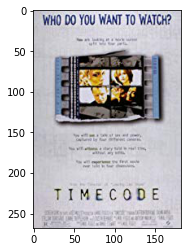

In [17]:
image_example = krs_image.load_img("filtered_img/tt0220100.png", target_size=(268,182))
image_example = krs_image.img_to_array(image_example,data_format="channels_last")
plt.imshow(image_example/255)
plt.show()

## Generador 

Como no es posible cargar todas las imagenes y los datos tabulares en memoria nos hemos visto obligados a generar nuestro propio generador que nos permitiera ir leyendo de manera dinámica batchs de x tamaño. 

Con el generador obtenemos un vector con las siguientes posiciones (el número de elementos por cada batch vendrá determinado por el batch que hemos puesto): 
1.   Imagenes
2.   Datos tabulares
3.   Etiquetas


    

In [0]:
# Creamos un generador vacio
datagen = ImageDataGenerator()


def custom_generator(images_list, dataframe, batch_size, numero_clases, 
                     path_imagenes = "filtered_img/",
                     name_target_colum= "RATING_CAT",
                     img_width = 182,
                     img_height = 268):
  
  """Generator.

    Keyword arguments:
    images_list -- lista con los nombres de la imagenes
    dataframe -- dataframe que contiene los datos tabulares
    batch_size -- tamaño del batch que queremos introducit a la red
    numero_clases -- número de clases de la variable de salida
    path_imagenes -- ruta a la carppeta donde estan las imagenes
    name_target_colum -- nombre de la columna que contiene la variable de salida
    img_width -- anchura de la imagen reducida 
    img_height -- altura de la imagen reducida
  """

  i = 0
  while True:
      batch = {'images': [], 'csv': [], 'labels': []}
      for b in range(batch_size):
          if i == len(images_list):
              i = 0
                
          # Leemos la Imagen
          image_path = images_list[i]
          #print(image_path)
          image = krs_image.load_img(path_imagenes+"tt"+str(image_path)+".png", target_size=(img_height,img_width))
          image = krs_image.img_to_array(image,data_format="channels_last")
        
          # Seleccionamos la fila correspondiente del csv
          csv_row = dataframe.loc[dataframe['CODE'] == image_path]
          #print(csv_row)
          # Selccionamos la etiqueta correspondiente
          label = csv_row[name_target_colum].values
          #print("ANTERIOR: ",label)
          label = tf.keras.utils.to_categorical(
              label, num_classes=numero_clases, dtype='int'
          )
          #print(label)
          
          # Selccionamos solo las features de ese registro
          csv_features = csv_row.drop(['CODE',name_target_colum],axis=1).values
          
          # insertamos en el diccionario los datos
          batch['images'].append(image)
          batch['csv'].append(csv_features)
          
          batch['labels'].append(label)
          #print("batch_labels: ",batch['labels'])

          i = i + 1
          
      batch['images'] = np.array(batch['images'])
      batch['csv'] = np.array(batch['csv'])
      batch['labels'] = np.array(batch['labels'])
      
      yield batch['images'], batch['csv'], batch['labels']

## Modelos Neuronales

Se van a crear tres modelos (1,2,3) cuya salida se concatenara y se pasará al modelo 4:

1.   Modelo para las imágenes
2.   Modelo para los datos tabulares
3.   Modelo de NLP
4.   Clasificador final




1.- Modelo para el procesamiento de los datos tabulares

In [0]:
def create_mlp_embedding(categorical_vars,numeric_vars,numeric_neurons):
  
  input_models=[]
  output_embeddings=[]

  for categorical_var in categorical_vars:
      
      cat_emb_name= categorical_var +'_Embedding'
      input_name= 'Input_' + categorical_var

      no_of_unique_cat  = X_train[categorical_var].nunique()
      
      embedding_size = int(min(np.ceil((no_of_unique_cat)/2), 100))  #Formula empírica
    
      input_model = Input(shape=(1,), name=input_name)
      
      output_model = Embedding(no_of_unique_cat, embedding_size, name=cat_emb_name)(input_model)
      output_model = Reshape(target_shape=(embedding_size,))(output_model)    

      input_models.append(input_model)

      output_embeddings.append(output_model)


  for numeric_var in numeric_vars:

    if numeric_var != 'CODE':
  
      input_numeric = Input(shape=(1,),name=numeric_var+"_Input")
      dense_numeric = Dense(numeric_neurons)(input_numeric) 
      input_models.append(input_numeric)
      output_embeddings.append(dense_numeric)

  #output = concatenate()(output_embeddings)
  output = Concatenate()(output_embeddings)
  #output = tf.keras.layers.Concatenate()(output_embeddings)

  model = Model(inputs=input_models, outputs=output)
  return model

2.- Modelo para el procesamiento de las imágenes

In [0]:
def create_cnn(width=182, height=268, depth=3, filters=(16, 32, 64)):
    
    inputShape = (height, width, depth)
    inputs = Input(shape=inputShape,name="IMG_Input")
    chanDim = -1
    # Bluce para crear tantas capas como queramos 
    for (i, f) in enumerate(filters):
        
        # Definimos la entrada para la primera neurona
        if i == 0:
            x = inputs
        
        # CONV => RELU => BN => POOL
        x = Conv2D(f, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)


    # Capa flatten para que nos devuelva un vector representativo de cada imágen
    x = Flatten()(x)
    x = Dense(16)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)
    x = Dense(4)(x)
    x = Activation("relu")(x)
   
    model = Model(inputs=inputs, outputs=x)
    # return the CNN
    return model

3.- Modelo para el procesamiento de lenguaje natural

4.- Concatenación de todos los modelos anteriores y hacer la clasificación

In [0]:
def create_model(option):

  mlp_emb = create_mlp_embedding(categorical_vars,numeric_vars,numeric_neurons)
  cnn = create_cnn(width=182, height=268, depth=3, filters=(16, 32, 64))

  if option == "cnn":

    x = Dense(512,activation='relu')(cnn.output)
    x = Dense(256,activation='relu')(x)
    x = Dense(3, activation='softmax')(x)
    model = Model(inputs=cnn.input, outputs=x)

  elif option == "mlp":

    x = Dense(512,activation='relu')(mlp_emb.output)
    x = Dense(256,activation='relu')(x)
    x = Dense(3, activation='softmax')(x)
    model = Model(inputs=mlp_emb.input, outputs=x)

  else:
    combinedInput = concatenate([mlp_emb.output, cnn.output])
    x = Dense(512,activation='relu')(combinedInput)
    x = Dense(256,activation='relu')(x)
    x = Dense(3, activation='softmax')(x)
    model = Model(inputs=[mlp_emb.input, cnn.input], outputs=x)

  return model

## Definición de parámetros 

In [0]:
# Generador
images_list = code_train_df['CODE'].values 
dataframe = code_train_df
batch_size = 2
numero_clases = 3
path_imagenes = "filtered_img/"
name_target_colum= "RATING_CAT"
img_width = 182
img_height = 268

# Modelos neuronales

## MLP
...
## CNN
depth=3 
filters=(16, 32, 64)

## Creaccion del generador

In [0]:
my_generator = custom_generator(images_list, dataframe, batch_size, numero_clases, path_imagenes, name_target_colum, img_width, img_height)

Código para comprobar que el generador funciona

In [24]:
code_train_df.head(4)

,COLOR,DIRECTOR,GENRES_0,GENRES_1,GENRES_2,LANGUAGE_0,COUNTRY_0,KEYWORDS_0,KEYWORDS_1,KEYWORDS_2,WRITERS_0,CODE,DURATION,YEAR,RATING_CAT
0,1,2895,5,6,5,52,54,1288,10354,1424,2409,0181574,90,1999,1
1,1,2895,2,8,2,161,157,5506,11300,6086,2409,1388925,84,1976,2
2,0,3469,8,8,8,149,147,9237,5794,3778,2409,0048799,111,1955,2
3,1,2895,5,13,5,97,93,17067,10354,18878,2409,1172550,118,2007,1


In [25]:
'''numero_batchs_example = 1

for i in range (0,numero_batchs_example):
    info = next(my_generator)
    #print(info)
    print("Features: ",info[1])
    print("labels: ",info[2])
    for img in info[0]:
        plt.imshow(img/255)
        plt.show()
    print("----------------------------------")
    print("----------------------------------")'''

'numero_batchs_example = 1\n\nfor i in range (0,numero_batchs_example):\n    info = next(my_generator)\n    #print(info)\n    print("Features: ",info[1])\n    print("labels: ",info[2])\n    for img in info[0]:\n        plt.imshow(img/255)\n        plt.show()\n    print("----------------------------------")\n    print("----------------------------------")'

### Creacción Modelo Neuronal

In [0]:
option = "both"
model = create_model(option)

In [27]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
IMG_Input (InputLayer)          [(None, 268, 182, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 268, 182, 16) 448         IMG_Input[0][0]                  
__________________________________________________________________________________________________
activation (Activation)         (None, 268, 182, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 268, 182, 16) 64          activation[0][0]                 
____________________________________________________________________________________________

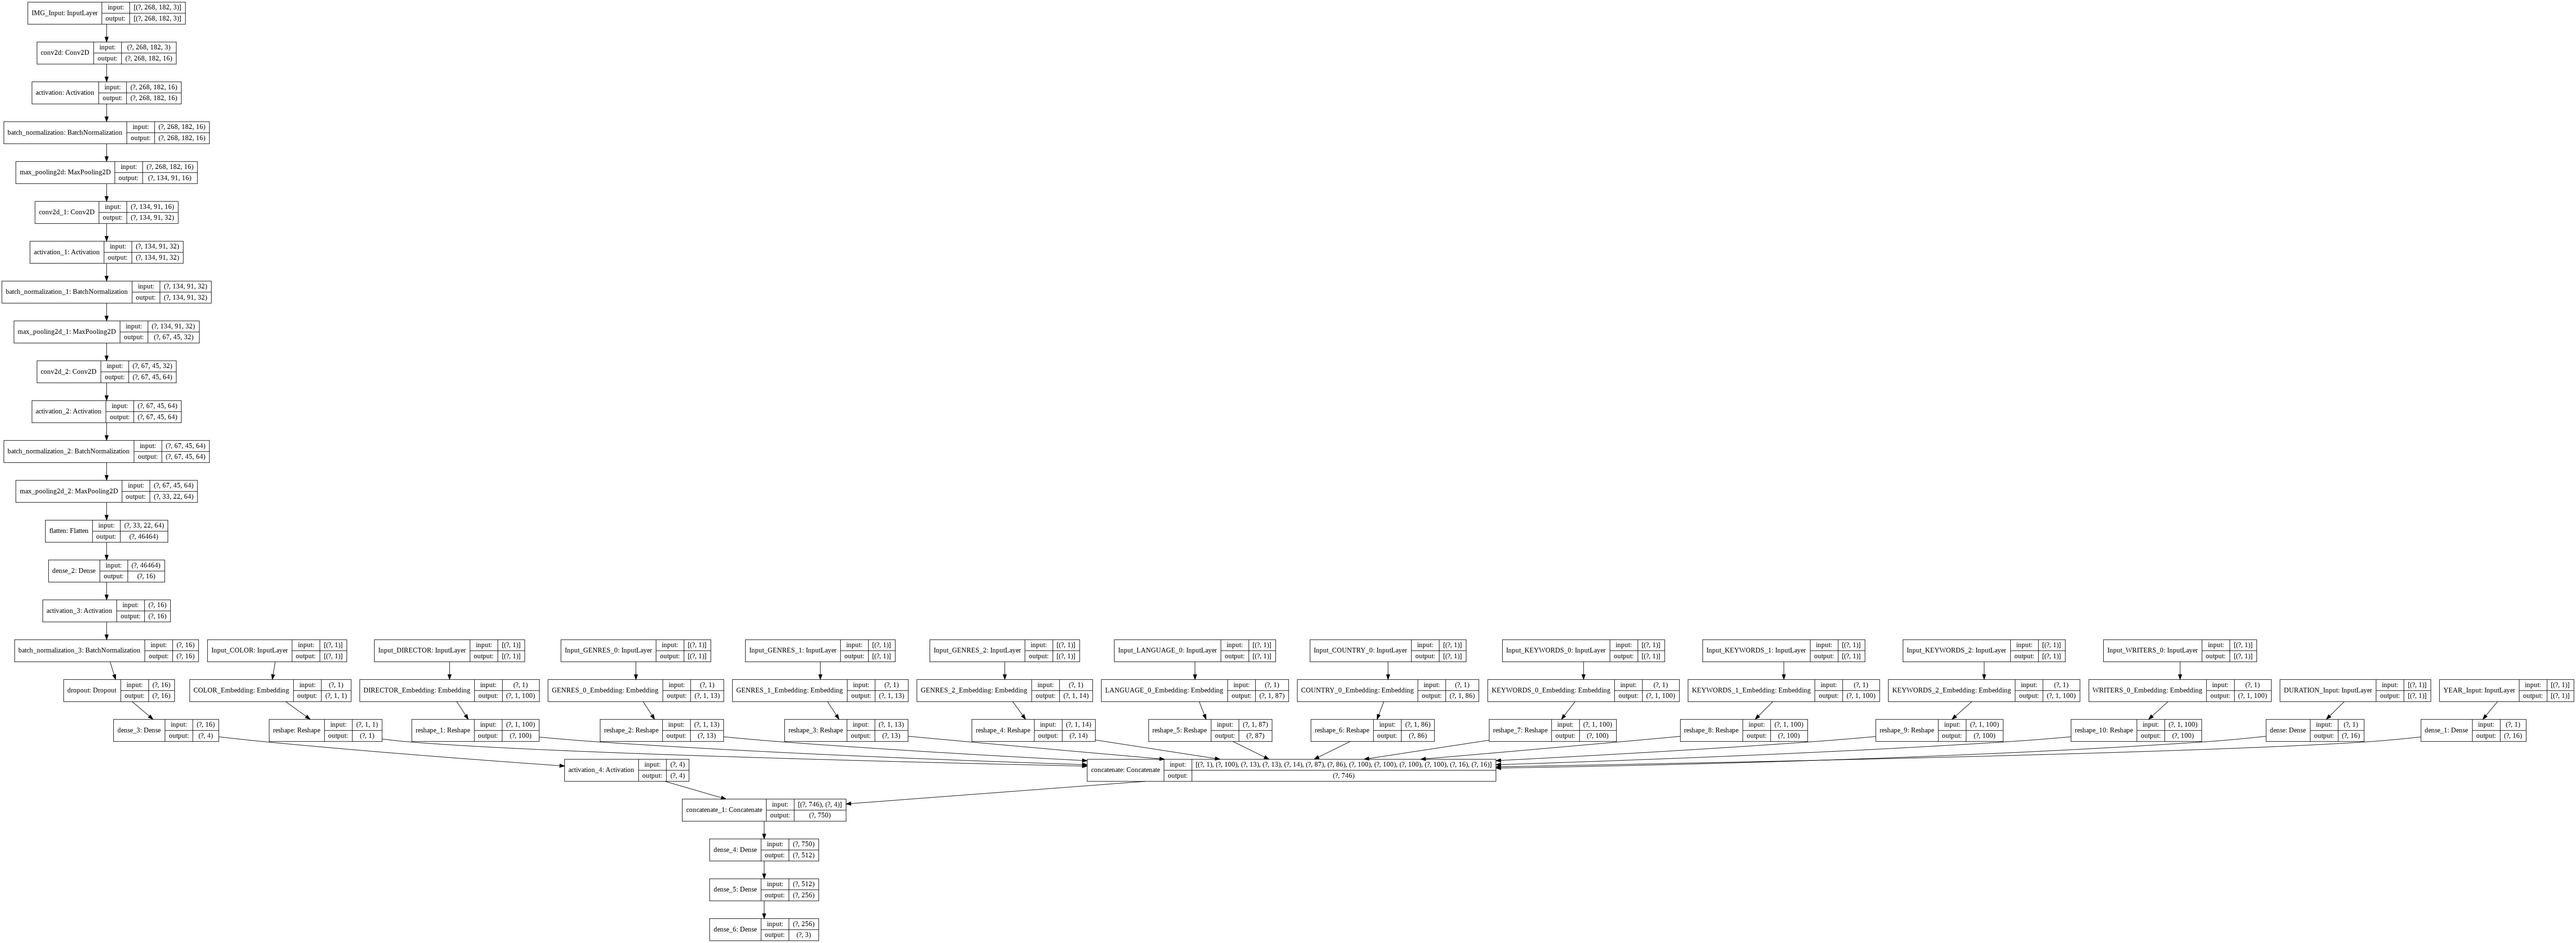

In [28]:
plot_model(model, to_file='model3.png',show_shapes=True,show_layer_names=True)
Image(retina=True, filename='model3.png')

### Entrenamiento

##### Modelado de los datos para introducirlos a la red

In [0]:
def tabular_data(data):

  mlp_input = np.squeeze(np.transpose(data))
  mlp_input = mlp_input.astype(int)

  print(mlp_input)

  tabular_dict= {
      'Input_COLOR':mlp_input[0],
      "Input_DIRECTOR":mlp_input[1],
      "Input_GENRES_0":mlp_input[2],
      "Input_GENRES_1":mlp_input[3],
      "Input_GENRES_2":mlp_input[4],
      "Input_LANGUAGE_0":mlp_input[5],
      "Input_COUNTRY_0":mlp_input[6],
      "Input_KEYWORDS_0":mlp_input[7],
      "Input_KEYWORDS_1":mlp_input[8],
      "Input_KEYWORDS_2":mlp_input[9],
      "Input_WRITERS_0":mlp_input[10],
      "DURATION_Input":mlp_input[11],
      "YEAR_Input":mlp_input[12]
 
    }

  return tabular_dict

def cnn_data(data):

  cnn_input = data/255
  cnn_input = cnn_input.astype(int)
  print("Shape de las Imgs:",cnn_input.shape)
  #cnn_input = {"IMG_Input":np.array(cnn_input)}

  return cnn_input

def target_data(data, batch_size, numero_clases):

  output = np.reshape(data, (batch_size, numero_clases))
  output = output.astype(int)

  return output


##### Compilación del modelo

In [0]:
sgd = SGD(lr=0.0000001)
model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])

In [34]:
num_features = 13

# Steps es el número de veces que tiene que iterar el bucle para recorrer todo el conjunto de datos
# steps = loguitud_total_del_dataset/tamaño_del_batch
steps = int(len(code_train_df)/batch_size)
print("El número de pasos es: ",steps)

# Número de veces que vamos a entrenar sobre el conjunto de entrenamiento
iteraciones = 1

for iteracion in tqdm(range(iteraciones)):
  print("Iteración número: ", iteracion)
  
  for step in tqdm(range(3)):
    
    print("Step número: ", step)

    # info va a contener tantos registros como tamaño del batch hemos puesto en el generador
    info = next(my_generator)
    #print("Tabular_Data: ",info[1])

    # LLamadas a las funciones que devuelven los datos con el formato correcto
    input_dict = tabular_data(info[1])
    cnn_input = cnn_data(info[0])

    #input_dict.update(cnn_input)

    print("All data: ", input_dict)

    output = target_data(info[2], batch_size, numero_clases)
   
    print("Salida esperada: ",output)

    model.fit([input_dict,[cnn_input]], output, epochs=1, verbose=True)
    #model.fit(input_dict, output, epochs=1, verbose=True)
    #model.fit(cnn_input, output, epochs=1, verbose=True)
    #model.fit([np.reshape(info[1], (batch_size, num_features)), info[0]/255], np.reshape(info[2], (batch_size, numero_clases)),epochs=1,verbose=True)
    print("----------------------------------")
    print("----------------------------------")

  0%|          | 0/3 [00:00<?, ?it/s]

El número de pasos es:  42872
Iteración número:  0
Step número:  0
[[    1     1]
 [ 2895  2895]
 [    8     5]
 [   10     8]
 [    8     5]
 [   72   118]
 [   77    70]
 [16688 11791]
 [ 8050   579]
 [12924 14856]
 [ 2409  2409]
 [  103   137]
 [ 2016  1974]]
Shape de las Imgs: (2, 268, 182, 3)
All data:  {'Input_COLOR': array([1, 1]), 'Input_DIRECTOR': array([2895, 2895]), 'Input_GENRES_0': array([8, 5]), 'Input_GENRES_1': array([10,  8]), 'Input_GENRES_2': array([8, 5]), 'Input_LANGUAGE_0': array([ 72, 118]), 'Input_COUNTRY_0': array([77, 70]), 'Input_KEYWORDS_0': array([16688, 11791]), 'Input_KEYWORDS_1': array([8050,  579]), 'Input_KEYWORDS_2': array([12924, 14856]), 'Input_WRITERS_0': array([2409, 2409]), 'DURATION_Input': array([103, 137]), 'YEAR_Input': array([2016, 1974])}
Salida esperada:  [[0 0 1]
 [0 1 0]]


  0%|          | 0/1 [00:00<?, ?it/s]


InvalidArgumentError: ignored

In [0]:
code_train_df.head(10)

In [0]:
cnn_input

array([[[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        ...,

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]],


       [[[1, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[1, 0, 0],
         [0,

In [0]:
A = input_dict['DURATION_Input']
A[2]

IndexError: ignored

In [0]:
input_dict

{'DURATION_Input': array([ 80, 142]),
 'Input_COLOR': array([1, 0]),
 'Input_COUNTRY_0': array([ 70, 141]),
 'Input_DIRECTOR': array([2893, 2893]),
 'Input_GENRES_0': array([13,  8]),
 'Input_GENRES_1': array([16,  8]),
 'Input_GENRES_2': array([24,  8]),
 'Input_KEYWORDS_0': array([14750,   811]),
 'Input_KEYWORDS_1': array([17551,   852]),
 'Input_KEYWORDS_2': array([10409, 15578]),
 'Input_LANGUAGE_0': array([40,  8]),
 'Input_WRITERS_0': array([2410, 2410]),
 'YEAR_Input': array([2015, 1977])}